In [ ]:
!pip install datasets

import tensorflow as tf


In [ ]:
from huggingface_hub import login

login()


In [ ]:
from datasets import load_dataset
import pandas as pd

# Dataset'i HF'ten çek
ds = load_dataset("turkish-nlp-suite/InstrucTurca", split="train")

# Eğitime uygun bir alt küme seç
sample_size = 600000
if sample_size > len(ds):
    sample_size = len(ds)

ds_small = ds.shuffle(seed=42).select(range(sample_size))

# Pandas DataFrame'e çevir
df = ds_small.to_pandas()

# InstrucTurca'daki kolon adları: "Input" ve "Output"
df["input"] = df["Input"].astype(str)
df["output"] = df["Output"].astype(str)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train.jsonl:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2575505 [00:00<?, ? examples/s]

In [ ]:
import re

def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-zA-Zçğıöşü0-9\s]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["input_clean"] = df["input"].apply(clean_text)
df["output_clean"] = df["output"].apply(clean_text)

bad_patterns = [
    "bir yapay zeka dil modeli olarak",
    "yapay zeka dil modeli olarak",
    "güncel bilgilere erişimim yok",
    "guncel bilgilere erisimim yok",
    "kisisel goruslerim yok",
]

mask = ~df["output_clean"].str.contains("|".join(bad_patterns), na=False)
df = df[mask].reset_index(drop=True)

# Decoder için start/end tokenları ekle
df["decoder_input"] = "<start> " + df["output_clean"]
df["decoder_output"] = df["output_clean"] + " <end>"

df[["input_clean", "decoder_input", "decoder_output"]].head()


,input_clean,decoder_input,decoder_output
0,size balıkların koruma kapsamında olduğunu söy...,<start> hayır doğru cevap balık olacaktır,hayır doğru cevap balık olacaktır <end>
1,yüksek kullanıma sahip kişisel eşyaları hesapl...,<start> bu işlevselliğin rustta olası bir uygu...,bu işlevselliğin rustta olası bir uygulaması a...
2,kısa bir cümle yazın,<start> adım 1 cümle için bir konu seçin konu ...,adım 1 cümle için bir konu seçin konu olarak k...
3,aşağıdaki biyografiden david sturrock hakkında...,<start> verilen biyografiden david sturrock ha...,verilen biyografiden david sturrock hakkında b...
4,paylaşılan alanlarda yüksek hijyeni belirlemek...,<start> ortak alanların temizliği ve dezenfeks...,ortak alanların temizliği ve dezenfeksiyonuna ...


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

num_words =30000

# ---- INPUT tarafı için tokenizer ----
tokenizer_inputs = Tokenizer(num_words=num_words, filters="", oov_token="<unk>")
tokenizer_inputs.fit_on_texts(df["input_clean"].values)

# ---- OUTPUT tarafı için tokenizer ----
tokenizer_outputs = Tokenizer(num_words=num_words, filters="")
tokenizer_outputs.fit_on_texts(
    list(df["decoder_input"].values) + list(df["decoder_output"].values)
)

# Metinleri sayılara çevir
encoder_input_seqs = tokenizer_inputs.texts_to_sequences(df["input_clean"].values)
decoder_input_seqs = tokenizer_outputs.texts_to_sequences(df["decoder_input"].values)
decoder_output_seqs = tokenizer_outputs.texts_to_sequences(df["decoder_output"].values)

# Ham maksimum uzunlukları bul
raw_max_len_input = max(len(seq) for seq in encoder_input_seqs)
raw_max_len_output = max(len(seq) for seq in decoder_input_seqs)

# Çok uzun cümleleri kırpalım
max_len_input = min(raw_max_len_input, 40)
max_len_output = min(raw_max_len_output, 40)

# Sabit uzunlukta olacak şekilde padding (post)
encoder_input_data = pad_sequences(encoder_input_seqs, maxlen=max_len_input, padding="post", truncating="post")
decoder_input_data = pad_sequences(decoder_input_seqs, maxlen=max_len_output, padding="post", truncating="post")
decoder_output_data = pad_sequences(decoder_output_seqs, maxlen=max_len_output, padding="post", truncating="post")


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam

# Sözlük boyutları
num_encoder_tokens = min(num_words, len(tokenizer_inputs.word_index) + 1)
num_decoder_tokens = min(num_words, len(tokenizer_outputs.word_index) + 1)

latent_dim = 512
embedding_dim = 320

# -------- ENCODER --------
encoder_inputs = Input(shape=(None,), name="encoder_inputs")
enc_emb = Embedding(
    num_encoder_tokens,
    embedding_dim,
    name="encoder_embedding"
)(encoder_inputs)

encoder_lstm = LSTM(
    latent_dim,
    return_state=True,
    name="encoder_lstm",
    dropout=0.3,
)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# -------- DECODER --------
decoder_inputs = Input(shape=(None,), name="decoder_inputs")
decoder_embedding = Embedding(
    num_decoder_tokens,
    embedding_dim,
    name="decoder_embedding"
)
dec_emb = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(
    latent_dim,
    return_sequences=True,
    return_state=True,
    name="decoder_lstm",
    dropout=0.3,
)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation="softmax", name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)

# Tam eğitim modeli (encoder + decoder birlikte)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = Adam(learning_rate=5e-4, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 320) │  9,600,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 320) │  9,600,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 512),     │  1,705,984 │ encoder_embeddin… │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │  1,705,984 │ decoder_embeddin… │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │ 15,390,000 │ decoder_lstm[0][… │
│ (Dense)             │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,001,968 (144.97 MB)

 Trainable params: 38,001,968 (144.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1) Padding (0) olan timestepleri masklemek için sample_weight
decoder_sample_weights = (decoder_output_data != 0).astype("float32")

# 2) EarlyStopping ve ModelCheckpoint
es = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

mc = ModelCheckpoint(
    "best_instrucTurca_seq2seq.keras",
    monitor="val_loss",
    save_best_only=True
)

# 3) Eğit
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_output_data,
    batch_size=64,
    epochs=30,
    validation_split=0.1,
    sample_weight=decoder_sample_weights,
    callbacks=[es, mc]
)


Epoch 1/30
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 680s 81ms/step - accuracy: 0.1040 - loss: 5.1456 - val_accuracy: 0.1948 - val_loss: 3.8671
Epoch 2/30
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 674s 81ms/step - accuracy: 0.2017 - loss: 3.7415 - val_accuracy: 0.2214 - val_loss: 3.5222
Epoch 3/30
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 673s 81ms/step - accuracy: 0.2255 - loss: 3.4179 - val_accuracy: 0.2356 - val_loss: 3.3566
Epoch 4/30
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 674s 81ms/step - accuracy: 0.2400 - loss: 3.2214 - val_accuracy: 0.2448 - val_loss: 3.2586
Epoch 5/30
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 674s 81ms/step - accuracy: 0.2506 - loss: 3.0959 - val_accuracy: 0.2506 - val_loss: 3.1967
Epoch 6/30
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 675s 81ms/step - accuracy: 0.2579 - loss: 2.9953 - val_accuracy: 0.2545 - val_loss: 3.1561
Epoch 7/30
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 673s 81ms/step - accuracy: 0.2642 - loss: 2.9200 - val_accuracy: 0.2573 - val_loss: 3.1289
Epoch 8/30
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 674s 81ms/step - accuracy: 

In [ ]:
# 1) Encoder modeli (girdiyi alıp state dönen)
encoder_model = Model(encoder_inputs, encoder_states)

# 2) Decoder için girişler (bir önceki LSTM state'leri)
decoder_state_input_h = Input(shape=(latent_dim,), name="decoder_state_input_h")
decoder_state_input_c = Input(shape=(latent_dim,), name="decoder_state_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder giriş kelimesi
decoder_inputs_single = Input(shape=(None,), name="decoder_inputs_single")
dec_emb2 = decoder_embedding(decoder_inputs_single)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs
)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

# Index -> kelime map'i
index_to_word_target = {i: w for w, i in tokenizer_outputs.word_index.items()}
word_to_index_target = tokenizer_outputs.word_index
word_to_index_input = tokenizer_inputs.word_index


In [ ]:
def decode_sequence(input_text, max_len=max_len_output, temperature=0.6, top_k=40):
    input_text_clean = clean_text(input_text)

    seq = tokenizer_inputs.texts_to_sequences([input_text_clean])
    enc_input = pad_sequences(seq, maxlen=max_len_input, padding="post", truncating="post")

    states_value = encoder_model.predict(enc_input)

    start_token = word_to_index_target.get("<start>")
    if start_token is None:
        raise ValueError("'<start>' tokenu yok.")

    target_seq = np.array([[start_token]])

    decoded_sentence = []
    seen_trigrams = set()

    max_steps = max_len

    for _ in range(max_steps):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        next_token_probs = output_tokens[0, -1, :]

        sampled_token_index = sample_with_temperature(
            next_token_probs, temperature=temperature, top_k=top_k
        )

        sampled_word = index_to_word_target.get(sampled_token_index, "")

        if sampled_word in ["", "<end>"]:
            break

        decoded_sentence.append(sampled_word)

        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    sentence = " ".join(decoded_sentence)
    sentence = postprocess_response(sentence)
    return sentence


In [ ]:
!pip install gradio -q


In [ ]:
import gradio as gr

def chat_with_bot(user_text):
    if not user_text.strip():
        return "Bir şey yazmadın 🙂"
    try:
        reply = decode_sequence(user_text)
        return reply
    except Exception as e:
        return f"Hata oluştu: {e}"


In [ ]:
demo = gr.Interface(
    fn=chat_with_bot,
    inputs=gr.Textbox(lines=2, placeholder="Bir şey yaz...", label="Sen"),
    outputs=gr.Textbox(lines=3, label="Bot"),
    title="Mini Chatbot",
    description="Kendi eğittiğin Seq2Seq LSTM chatbot 😊"
)

demo.launch()


/tmp/ipython-input-446953923.py:55: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme="soft", css=custom_css) as demo:
/tmp/ipython-input-446953923.py:55: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(theme="soft", css=custom_css) as demo:
/tmp/ipython-input-446953923.py:59: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Sohbet Ekranı", height=350)
/tmp/ipython-input-446953923.py:59: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot wil

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5d7ddefa556e829c18.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


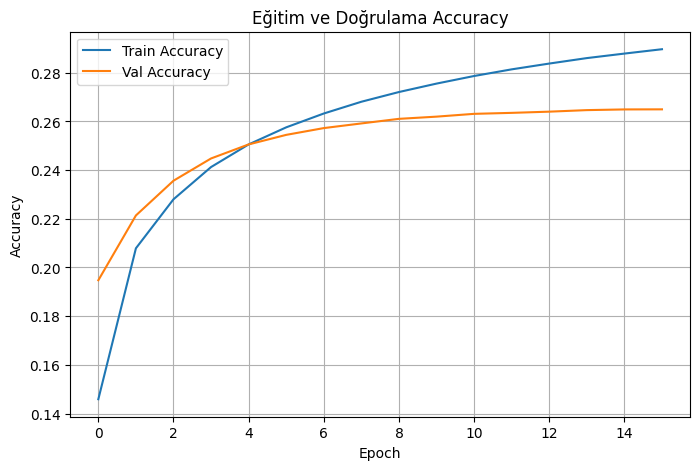

In [ ]:
# Accuracy grafiği
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Eğitim ve Doğrulama Accuracy")
plt.legend()
plt.grid(True)
plt.show()


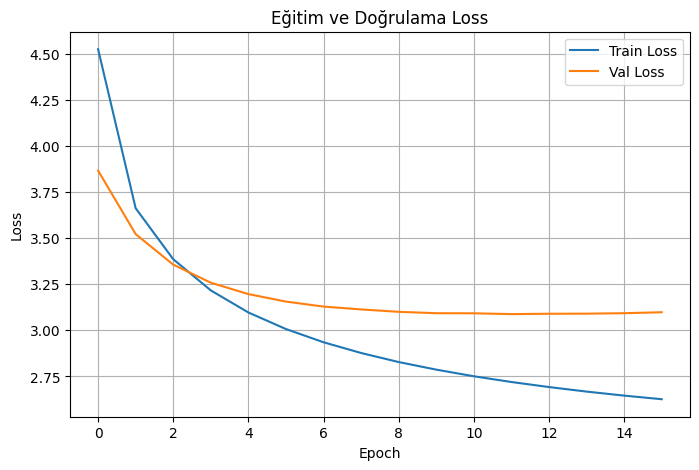

In [ ]:
import matplotlib.pyplot as plt

# Loss grafiği
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Loss")
plt.legend()
plt.grid(True)
plt.show()
